In [105]:
# 농수축 & 이미용 EDAddd
# !pip install plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm.notebook import tqdm
import requests
import xmltodict
import re
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# pd.set_option('display.max_rows', 100)
%matplotlib inline
plt.style.use('ggplot') # 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.rcParams['font.family'] = 'Malgun Gothic'

# model_df 외부변수 추가 안한 상태

In [104]:
sum_df = pd.read_csv('c:/bc/sum_df.csv')
sum_df.head()

,broadcast,exp_min,m_code,p_code,p_name,p_group,unit_price,total_price,sales,YEAR,...,DAY_NUM,p_group_code,new_code,no,sales_level,grade,season,timeslot,holiday,sales_group
0,2019-01-01 06:00:00,60.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,32696000.0,820.0,2019,...,2,0,13.0,0,b,4,4,1,1,2.0
1,2019-01-01 07:00:00,60.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,47878000.0,812.0,2019,...,2,1,7.0,6,b,4,4,1,1,2.0
2,2019-01-01 08:00:00,60.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,의류,59900,99736000.0,1665.0,2019,...,2,0,16.0,9,d,3,4,1,1,4.0
3,2019-01-01 09:00:00,60.0,100816,202404,보코 리버시블 무스탕,의류,79000,90973000.0,1151.0,2019,...,2,0,18.0,12,c,3,4,2,1,3.0
4,2019-01-01 10:00:00,60.0,100809,202395,CERINI by PAT 남성 풀패키지 기모니트 3종,의류,79900,259678000.0,3250.0,2019,...,2,0,17.0,15,e,2,4,2,1,5.0


In [ ]:
sum_df = sum_df[(sum_df['sales_group'] >= 4)|(sum_df['sales_group'] <= 2)].reset_index(drop=True)

In [44]:
sum_df['score'] = 'temp'
for row, value in enumerate(sum_df.sales_group):
    if value <= 2:
        sum_df.score[row] = 0
    elif value >= 4:
        sum_df.score[row] = 1

C:\Users\moon\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\moon\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [87]:
interested_group = list(sum_df.p_group.unique())

group_solution_dict = {}

for group in interested_group:
    df = sum_df[sum_df['p_group']==group]
    solution_list = []
    df_total_sales = df.sales.sum()
    print(group,'의 unit_price 개수:',len(df.unit_price.unique()))
    for idx, x in enumerate(sorted(df.unit_price.unique())):
        if idx % 10 == 0:
            print(idx, x)
        for y in sorted(df.unit_price.unique()):
            if x >= y:
                continue
            elif ((df[(df['unit_price'] >= x) & (df['unit_price'] <= y)].sales.sum() / df_total_sales) >= 0.495) &\
            ((df[(df['unit_price'] >= x) & (df['unit_price'] <= y)].sales.sum() / df_total_sales) <= 0.505):
                solution_list.append((x,y))
    group_solution_dict[group]=solution_list
group_solution_dict

의류 의 unit_price 개수: 48
0 29000
10 44900
20 66000
30 129000
40 399000
속옷 의 unit_price 개수: 26
0 29900
10 63200
20 109000
주방 의 unit_price 개수: 75
0 24900
10 50900
20 64800
30 79800
40 93000
50 123000
60 179000
70 254000
농수축 의 unit_price 개수: 34
0 28900
10 41900
20 55900
30 73900
이미용 의 unit_price 개수: 14
0 39800
10 69800
가전 의 unit_price 개수: 33
0 164000
10 829000
20 1330000
30 1959000
생활용품 의 unit_price 개수: 61
0 12800
10 39900
20 52900
30 89000
40 129000
50 219000
60 1880000
건강기능 의 unit_price 개수: 26
0 39900
10 69900
20 129000
잡화 의 unit_price 개수: 50
0 29000
10 49800
20 79800
30 169000
40 380000
가구 의 unit_price 개수: 18
0 89000
10 799000
침구 의 unit_price 개수: 9
0 39900


{'의류': [(29000, 49800),
  (34000, 59000),
  (40800, 79000),
  (44000, 79000),
  (49800, 299000),
  (49800, 399000),
  (49800, 499000),
  (49800, 690000),
  (49900, 399000),
  (49900, 499000),
  (49900, 690000),
  (49900, 699000),
  (49900, 1490000),
  (49900, 1590000),
  (49900, 1690000),
  (49900, 2490000)],
 '속옷': [(59900, 109000)],
 '주방': [(24900, 89000),
  (29800, 89000),
  (39900, 89800),
  (39900, 90000),
  (39900, 90800),
  (39900, 93000),
  (41900, 99000),
  (41900, 104000),
  (49000, 99000),
  (49000, 104000),
  (49800, 104000),
  (61800, 154000),
  (79800, 198000),
  (79900, 198000),
  (79900, 199000),
  (80000, 198000),
  (80000, 199000),
  (80000, 208000),
  (84000, 198000),
  (84000, 199000),
  (84000, 208000),
  (84800, 208000),
  (88800, 209000),
  (88800, 219000),
  (88800, 228000),
  (88800, 229000),
  (89000, 209000),
  (89000, 219000),
  (89000, 228000),
  (89000, 229000),
  (89000, 238000),
  (89000, 239000),
  (89000, 254000),
  (89000, 259000),
  (89000, 309000),


In [100]:
with open('c:/bc/high_perform_dict.pickle', 'rb') as f:
    high_perform_dict = pickle.load(f)
    
with open('c:/bc/low_perform_dict.pickle', 'rb') as f:
    low_perform_dict = pickle.load(f)    

In [45]:
model_df = sum_df[['p_group','exp_min','unit_price','DAY_NUM','season','timeslot','holiday','score']]

model_df.timeslot = model_df.timeslot.astype('int64')
model_df = pd.get_dummies(model_df, columns=['DAY_NUM'])
model_df = pd.get_dummies(model_df, columns=['season'])
model_df = pd.get_dummies(model_df, columns=['timeslot'])
model_df = pd.get_dummies(model_df, columns=['holiday'])

standardscaler = StandardScaler()
minmaxscaler = MinMaxScaler()

model_df[['exp_min','unit_price']] = minmaxscaler.fit_transform(model_df[['exp_min','unit_price']])

C:\Users\moon\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [65]:
def array_by_group(group):
    return np.array(model_df[model_df['p_group'] == group].iloc[:,1:]).astype('float64')

In [74]:
def feature_random_forest(group):
    data = array_by_group(group)

    x = data[:,0:-1]
    y = data[:,-1]

    trainX, testX, trainY, testY = train_test_split(x,y,test_size=0.2)

    rf = RandomForestClassifier(max_depth=5, n_estimators=100)
    rf.fit(trainX, trainY)
    fi = rf.feature_importances_
    fn = list(model_df.columns[1:])
    n_f = trainX.shape[1]
    idx = np.arange(n_f)
    plt.barh(idx,fi,align = 'center')
    plt.yticks(idx,fn,size=12)
    plt.show()

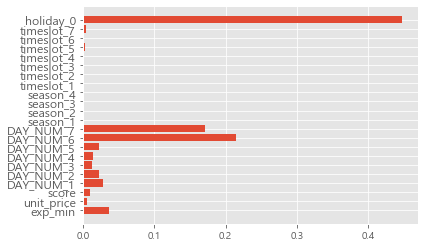

In [79]:
feature_random_forest('농수축')